# Profiling general GAN models

In [ ]:
import numpy as np

import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

In [ ]:
channels = 1 # suggested default : 1, number of image channels (gray scale)
img_size = 28 # suggested default : 28, size of each image dimension
img_shape = (channels, img_size, img_size) # (Channels, Image Size(H), Image Size(W))

In [ ]:
latent_dim = 100 # suggested default. dimensionality of the latent space

In [ ]:
cuda = True if torch.cuda.is_available() else False # GPU Setting

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(input_features, output_features, normalize=True):
            layers = [nn.Linear(input_features, output_features)]
            if normalize: # Default
                layers.append(nn.BatchNorm1d(output_features, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True)) # inplace=True : modify the input directly. It can slightly decrease the memory usage.
            return layers # return list of layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False), # Asterisk('*') in front of block means unpacking list of layers - leave only values(layers) in list
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))), # np.prod(1, 28, 28) == 1*28*28
            nn.Tanh() # result : from -1 to 1
        )

    def forward(self, z): # z == latent vector(random input vector)
        img = self.model(z) # (64, 100) --(model)--> (64, 784)
        img = img.view(img.size(0), *img_shape) # img.size(0) == N(Batch Size), (N, C, H, W) == default --> (64, 1, 28, 28)
        return img

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512), # (28*28, 512)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid() # result : from 0 to 1
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1) #flatten -> from (64, 1, 28, 28) to (64, 1*28*28)
        validity = self.model(img_flat) # Discriminate -> Real? or Fake? (64, 784) -> (64, 1)
        return validity

In [ ]:
adversarial_loss = torch.nn.BCELoss()

In [ ]:
generator = Generator()
discriminator = Discriminator()

In [ ]:
generator

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)

In [ ]:
discriminator

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [ ]:
if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

In [ ]:
import pandas as pd
from torch.utils.data import Dataset

In [ ]:
class DatasetMNIST(Dataset): # inherit abstract class - 'Dataset'

    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # load image ad ndarray type (H, W, C)
        # be carefull for converting dtype to np.uint8 (Unsigned integer (0 to 255))
        # in this example, We use ToTensor(), so we define the numpy array like (H, W, C)

        image = self.data.iloc[index, 1:].values.astype(np.uint8).reshape((28,28,1))
        label = self.data.iloc[index, 0]
        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [ ]:
train = pd.read_csv('../content/sample_data/train.csv')

In [ ]:
train

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
for index in range(1, 6): # N : 5 (Number of Image)
    temp_image = train.iloc[index, 1:].values.astype(np.uint8).reshape((28,28,1))
    temp_label = train.iloc[index, 0]
    print('Shape of Image : ',temp_image.shape)
    print('label : ', temp_label)

Shape of Image :  (28, 28, 1)
label :  0
Shape of Image :  (28, 28, 1)
label :  1
Shape of Image :  (28, 28, 1)
label :  4
Shape of Image :  (28, 28, 1)
label :  0
Shape of Image :  (28, 28, 1)
label :  0


In [ ]:
dataset = DatasetMNIST(file_path='../content/sample_data/train.csv',
                       transform=transforms.Compose(
                           [#transforms.Resize(img_size), # Resize is only for PIL Image. Not for numpy array
                            transforms.ToTensor(), # ToTensor() : np.array (H, W, C) -> tensor (C, H, W)
                            transforms.Normalize([0.5],[0.5])]
                       ))

In [ ]:
temp_img, _ =  dataset.__getitem__(0) # We don't need label, so _

In [ ]:
temp_img.size() # before ToTensor() : (28,28,1), after : (1,28,28)

torch.Size([1, 28, 28])

In [ ]:
temp_img.max(), temp_img.min() # before Normalize([0.5],[0.5]) : 0 ~ 1, after : -1 ~ 1

(tensor(1.), tensor(-1.))

In [ ]:
batch_size = 64 # suggested default, size of the batches
dataloader = DataLoader( # torch.utils.data.DataLoader
    dataset,
    batch_size=batch_size,
    shuffle=True
)

In [ ]:
#temp_images, _ = iter(dataloader).next() # We don't use label, so _
temp_images, _ = next(iter(dataloader)) # Solve the error of iter().next() without attribute next()
#dataiter = iter(dataloader)
#temp_images = next(dataiter)
print('images shape on batch size = {}'.format(temp_images.size()))

images shape on batch size = torch.Size([64, 1, 28, 28])


In [ ]:
# suggested default - beta parameters (decay of first order momentum of gradients)
b1 = 0.5
b2 = 0.999

# suggested default - learning rate
lr = 0.0002

In [ ]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1,b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1,b2))

In [ ]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
# Visualize result
import matplotlib.pyplot as plt

  0%|          | 0/657 [00:00<?, ?it/s]

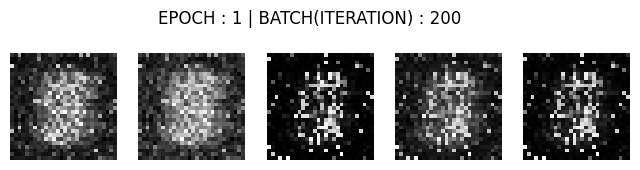

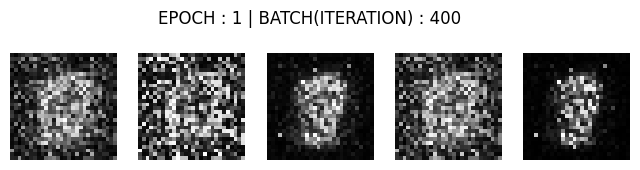

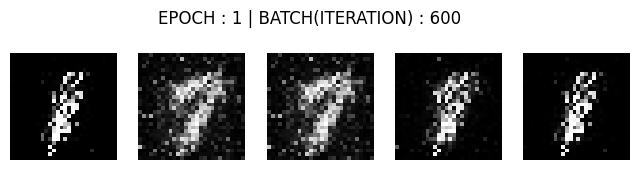

[Epoch: 1/10] [Batch: 657/657] [D loss: 0.480412] [G loss: 0.769393]


  0%|          | 0/657 [00:00<?, ?it/s]

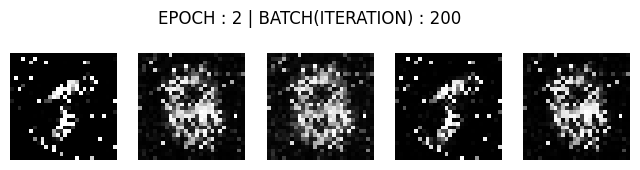

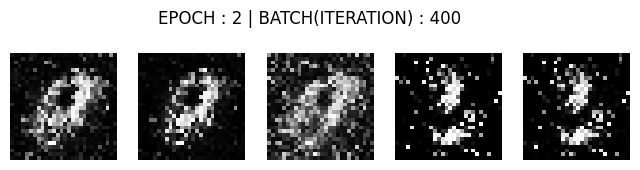

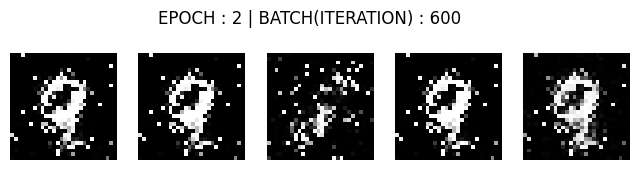

[Epoch: 2/10] [Batch: 657/657] [D loss: 0.476765] [G loss: 0.543024]


  0%|          | 0/657 [00:00<?, ?it/s]

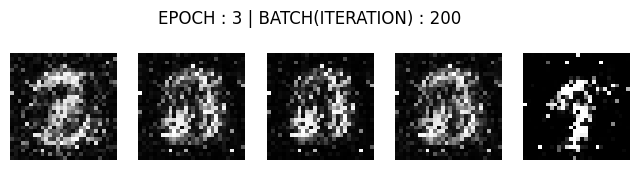

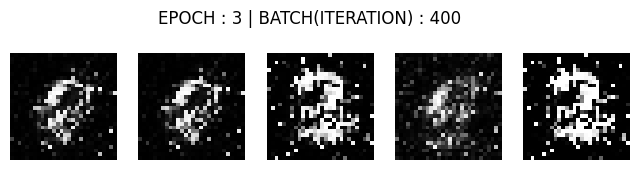

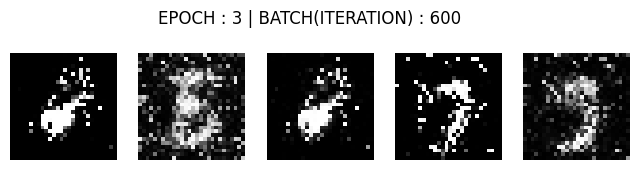

[Epoch: 3/10] [Batch: 657/657] [D loss: 0.234563] [G loss: 1.402298]


  0%|          | 0/657 [00:00<?, ?it/s]

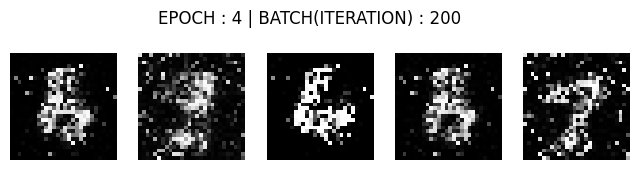

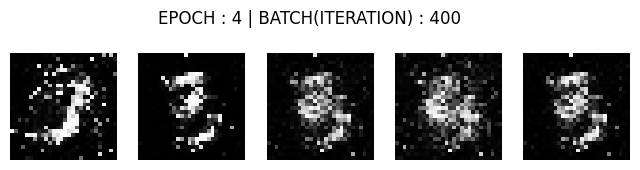

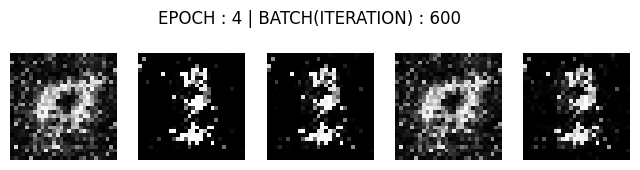

[Epoch: 4/10] [Batch: 657/657] [D loss: 0.301005] [G loss: 1.478847]


  0%|          | 0/657 [00:00<?, ?it/s]

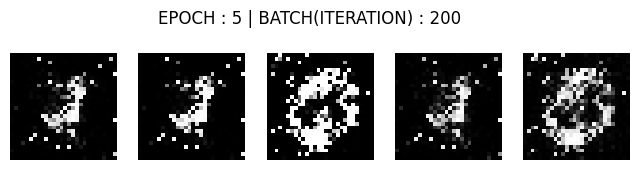

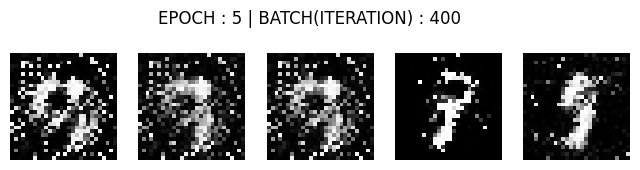

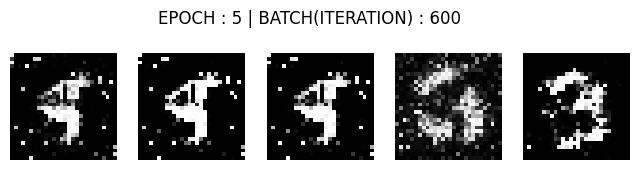

[Epoch: 5/10] [Batch: 657/657] [D loss: 0.606952] [G loss: 4.132804]


  0%|          | 0/657 [00:00<?, ?it/s]

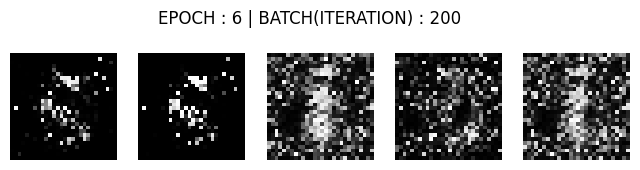

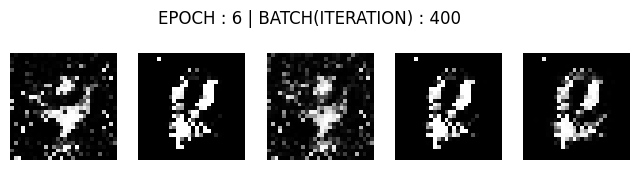

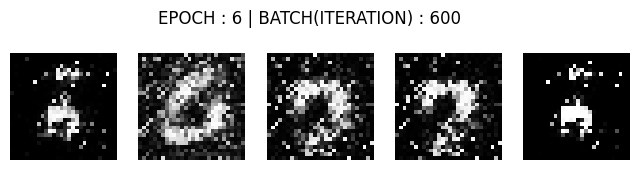

[Epoch: 6/10] [Batch: 657/657] [D loss: 0.156240] [G loss: 1.960537]


  0%|          | 0/657 [00:00<?, ?it/s]

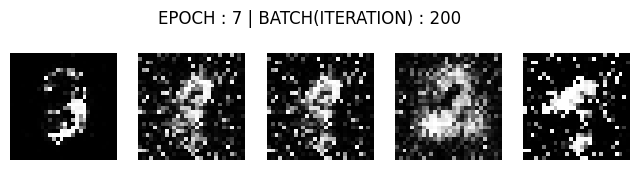

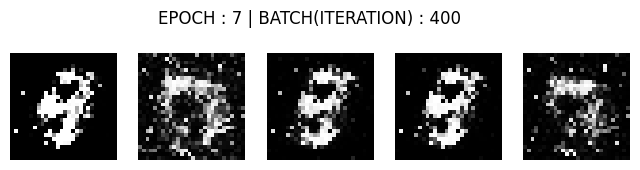

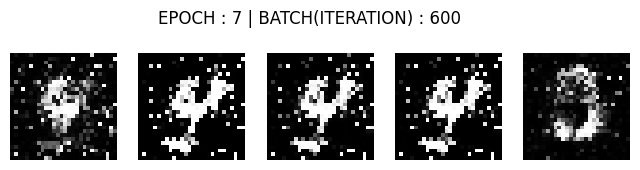

[Epoch: 7/10] [Batch: 657/657] [D loss: 0.340630] [G loss: 0.948930]


  0%|          | 0/657 [00:00<?, ?it/s]

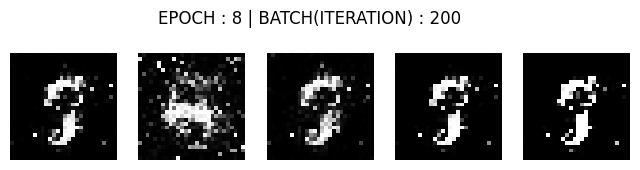

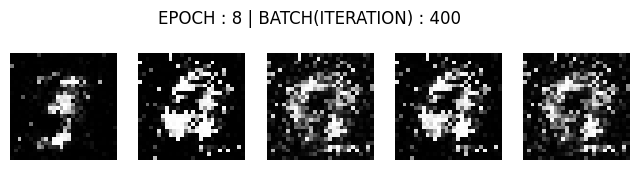

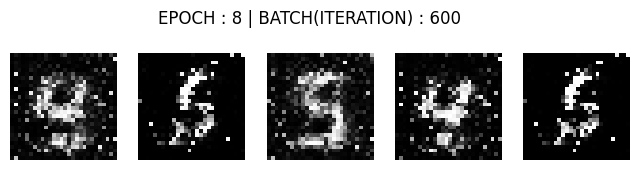

[Epoch: 8/10] [Batch: 657/657] [D loss: 0.249157] [G loss: 2.354025]


  0%|          | 0/657 [00:00<?, ?it/s]

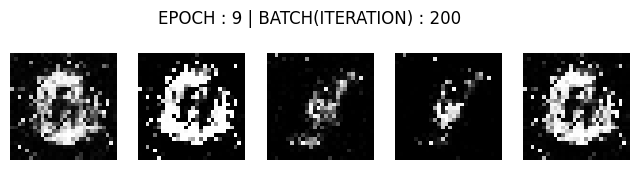

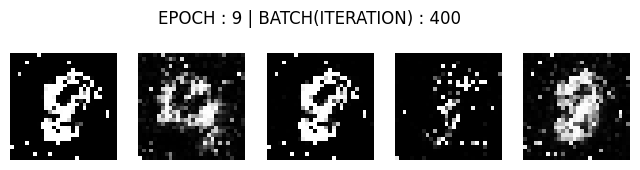

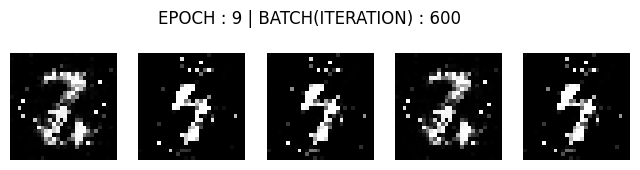

[Epoch: 9/10] [Batch: 657/657] [D loss: 0.583366] [G loss: 3.728917]


  0%|          | 0/657 [00:00<?, ?it/s]

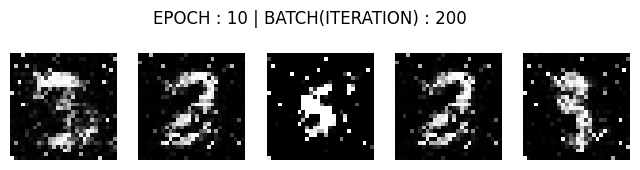

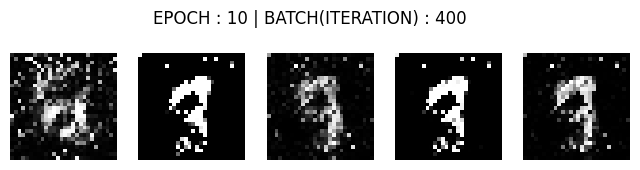

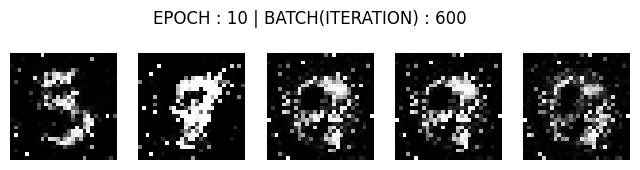

[Epoch: 10/10] [Batch: 657/657] [D loss: 0.195999] [G loss: 2.225638]


In [ ]:
n_epochs = 10 # suggested default = 200
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(tqdm(dataloader)): # This code(enumerate) is dealt with once more in the *TEST_CODE below.
                                                     # Used 'tqdm' for showing progress

        # Adversarial ground truths (For more detail, refer *Read_More below)
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False) # imgs.size(0) == batch_size(1 batch) == 64, *TEST_CODE
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False) # And Variable is for caclulate gradient. In fact, you can use it, but you don't have to.
                                                                                # requires_grad=False is default in tensor type. *Read_More

        # Configure input
        real_imgs = imgs.type(Tensor) # As mentioned, it is no longer necessary to wrap the tensor in a Variable.
      # real_imgs = Variable(imgs.type(Tensor)) # requires_grad=False, Default! It's same.

# ------------
# Train Generator
# ------------
        optimizer_G.zero_grad()

        # sample noise 'z' as generator input
        z = Tensor(np.random.normal(0, 1, (imgs.shape[0],latent_dim))) # Random sampling Tensor(batch_size, latent_dim) of Gaussian distribution
        # z.shape == torch.Size([64, 100])

        # Generate a batch of images
        gen_imgs = generator(z)
        # gen_imgs.shape == torch.Size([64, 1, 28, 28])

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid) # torch.nn.BCELoss() compare result(64x1) and valid(64x1, filled with 1)

        g_loss.backward()
        optimizer_G.step()

# ------------
# Train Discriminator
# ------------
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid) # torch.nn.BCELoss() compare result(64x1) and valid(64x1, filled with 1)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake) # We are learning the discriminator now. So have to use detach()

        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()# If didn't use detach() for gen_imgs, all weights of the generator will be calculated with backward().
        optimizer_D.step()



# ------------
# Real Time Visualization (While Training)
# ------------

        sample_z_in_train = Tensor(np.random.normal(0, 1, (imgs.shape[0],latent_dim)))
        # z.shape == torch.Size([64, 100])
        sample_gen_imgs_in_train = generator(sample_z_in_train).detach().cpu()
        # gen_imgs.shape == torch.Size([64, 1, 28, 28])

        if ((i+1) % 200) == 0: # show while batch - 200/657, 400/657, 600/657
            nrow=1
            ncols=5
            fig, axes = plt.subplots(nrows=nrow,ncols=ncols, figsize=(8,2))
            plt.suptitle('EPOCH : {} | BATCH(ITERATION) : {}'.format(epoch+1, i+1))
            for ncol in range(ncols):
                axes[ncol].imshow(sample_gen_imgs_in_train.permute(0,2,3,1)[ncol], cmap='gray')
                axes[ncol].axis('off')
            plt.show()
    print(
        "[Epoch: %d/%d] [Batch: %d/%d] [D loss: %f] [G loss: %f]"
        % (epoch+1, n_epochs, i+1, len(dataloader), d_loss.item(), g_loss.item())
    )

In [38]:
# result of enumerate
count = 1
for i, (imgs,label) in enumerate(dataloader):
    print('Shape of Batch Images : \n', imgs.shape)
    print('Labels (1~64) : \n', label)
    print('-'*100)
    if count == 5:
        break
    else:
        count += 1

Shape of Batch Images : 
 torch.Size([64, 1, 28, 28])
Labels (1~64) : 
 tensor([4, 4, 1, 2, 5, 3, 2, 4, 2, 0, 5, 5, 4, 6, 0, 9, 6, 2, 9, 9, 4, 3, 9, 1,
        3, 3, 0, 6, 3, 8, 2, 3, 9, 6, 7, 1, 0, 4, 8, 3, 4, 1, 7, 1, 1, 6, 9, 7,
        3, 6, 2, 1, 2, 3, 3, 2, 1, 0, 8, 2, 2, 5, 5, 0])
----------------------------------------------------------------------------------------------------
Shape of Batch Images : 
 torch.Size([64, 1, 28, 28])
Labels (1~64) : 
 tensor([5, 3, 2, 8, 4, 4, 3, 1, 8, 3, 7, 7, 6, 1, 7, 7, 3, 3, 1, 8, 6, 1, 4, 7,
        7, 0, 1, 7, 8, 9, 2, 7, 6, 1, 0, 9, 9, 8, 8, 8, 7, 5, 9, 7, 8, 6, 0, 7,
        4, 4, 2, 8, 1, 6, 9, 9, 0, 0, 8, 0, 0, 2, 2, 5])
----------------------------------------------------------------------------------------------------
Shape of Batch Images : 
 torch.Size([64, 1, 28, 28])
Labels (1~64) : 
 tensor([1, 5, 8, 7, 5, 5, 4, 4, 9, 2, 2, 3, 4, 8, 7, 4, 8, 9, 6, 1, 9, 1, 3, 9,
        7, 5, 2, 2, 3, 6, 4, 9, 6, 3, 5, 9, 9, 3, 9, 8, 7, 1, 1, 7, 

In [39]:
Tensor(10,1) # Just 10 for a quick look.
             # We dealt with Tensor(imgs.size(0),1) above. Tensor(64,1) <-- len(H) == batch_size == 64, len(W) == 1

tensor([[9.2337e-06],
        [0.0000e+00],
        [3.4622e-06],
        [0.0000e+00],
        [4.4842e-44],
        [0.0000e+00],
        [1.3452e-43],
        [0.0000e+00],
        [3.1616e-40],
        [0.0000e+00]])

In [40]:
Tensor(10,1).fill_(1.0) # _ means inplace, fill the Tensor with 1.0

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])

In [42]:
sample_img = next(iter(dataloader))[0]

In [43]:
sample_img.shape, sample_img.dtype

(torch.Size([64, 1, 28, 28]), torch.float32)

In [44]:
sample_img.requires_grad # default : False

False

In [45]:
Variable(sample_img).requires_grad # exactly same

False

In [46]:
sample_img.requires_grad_(True) # set requires_grad to True, _ means inplace

tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        ...,


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., 

In [47]:
sample_img.requires_grad # Yes. requires_grad changed correctly. you don't need wrapping tensor with Variable.

True

In [48]:
np.random.normal(0,1,(64,100))

array([[ 1.18378622,  0.18056525,  0.11332145, ..., -0.87010455,
         0.78690934, -1.66193534],
       [-0.1492298 ,  0.87241573,  0.14556192, ..., -1.01267381,
         1.13717677, -0.7485692 ],
       [ 1.198632  , -1.72050057, -0.78125953, ...,  1.36514815,
         0.35530385,  0.33627343],
       ...,
       [ 0.6246795 ,  0.45425527, -1.41719488, ...,  0.61328708,
         0.76081172, -0.99983279],
       [-1.54862301,  0.25070702,  0.82275259, ..., -0.22597204,
         0.88255755, -0.34770689],
       [-0.92534452,  0.49700081, -2.91940195, ...,  0.6917032 ,
         1.07774226,  0.31588538]])

In [49]:
np.random.normal(0,1,(64,100)).shape

(64, 100)

In [50]:
# latent vector
sample_z = Tensor(np.random.normal(0, 1, (64,100)))
sample_z.shape

torch.Size([64, 100])

In [51]:
# generated images
sample_gen_imgs = generator(sample_z)
sample_gen_imgs.shape

torch.Size([64, 1, 28, 28])

In [52]:
# discrimination result
sample_discrim_result = discriminator(sample_gen_imgs)
sample_discrim_result.shape

torch.Size([64, 1])

In [53]:
adversarial_loss

BCELoss()

In [54]:
sample_valid = Tensor(64,1).fill_(1.0)
sample_g_loss = adversarial_loss(sample_discrim_result, sample_valid)
sample_g_loss

tensor(1.6140, grad_fn=<BinaryCrossEntropyBackward0>)

In [55]:
!pip install torchviz
import torchviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

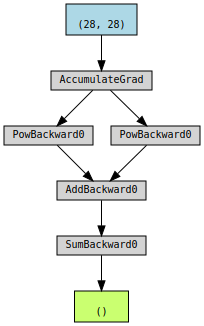

In [56]:
X = torch.ones((28,28), dtype=torch.float32, requires_grad=True)
square_X = X**2
cubic_X = X**3

result = (square_X+cubic_X).sum()

torchviz.make_dot(result)

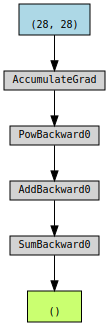

In [57]:
X = torch.ones((28,28), dtype=torch.float32, requires_grad=True)
square_X = X**2
cubic_X = X.detach()**3

result = (square_X+cubic_X).sum()

torchviz.make_dot(result)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')